In [1]:
# !pip3 install http://download.pytorch.org/wh1/cu80/torch-0.4.1-cp36-cp36m-linux_x86_64.whl

In [2]:
# !pip3 install torchvision

In [3]:
# !pip install tensorboardX

In [4]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

import numpy as np
import datetime
import os, sys
import glob
from PIL import Image
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [5]:
MODEL_NAME = 'DCGAN'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

IMAGE_DIM = (32, 32, 3)

def get_sample_image(G, n_noise):
    """
        save sample 100 images
    """
    z = torch.randn(10, n_noise).to(DEVICE)
    
    y_hat = G(z).view(10, 3, 32, 32).permute(0, 2, 3, 1) # (100, 28, 28)
    result = (y_hat.detach().cpu().numpy()+1)/2.
    return result

In [6]:
print(DEVICE)

cuda:0


In [7]:
class Discriminator(nn.Module):
    """
        Convolutional Discriminator for MNIST
    """
    def __init__(self, in_channel=1, num_classes=1):
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
            # 28 -> 14
            nn.Conv2d(in_channel, 512, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            # 14 -> 7
            nn.Conv2d(512, 256, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            # 7 -> 4
            nn.Conv2d(256, 128, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            #
            nn.Conv2d(128, 128, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.AdaptiveAvgPool2d(1),
        )
        self.fc = nn.Sequential(
            # reshape input, 128 -> 1
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x, y=None):
        y_ = self.conv(x)
        y_ = y_.view(y_.size(0), -1)
        y_ = self.fc(y_)
        return y_

In [8]:
class Generator(nn.Module):
    """
        Convolutional Generator for MNIST
    """
    def __init__(self, out_channel=1, input_size=100, num_classes=784):
        super(Generator, self).__init__()
        assert IMAGE_DIM[0] % 2**4 == 0, 'Should be divided 16'
        self.init_dim = (IMAGE_DIM[0] // 2**4, IMAGE_DIM[1] // 2**4)
        self.fc = nn.Sequential(
            nn.Linear(input_size, self.init_dim[0]*self.init_dim[1]*512),
            nn.ReLU(),
        )
        self.conv = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # x2
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # x2
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # x2
            nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # x2
            nn.ConvTranspose2d(128, out_channel, 4, stride=2, padding=1, bias=False),
            nn.Tanh(),
        )

    def forward(self, x, y=None):
        x = x.view(x.size(0), -1)
        y_ = self.fc(x)
        y_ = y_.view(y_.size(0), 512, self.init_dim[0], self.init_dim[1])
        y_ = self.conv(y_)
        return y_

In [9]:
class CARS(Dataset):
    def __init__(self, data_path, transform=None):
        '''
        Args:
            data_path (str): path to dataset
        '''
        self.data_path = data_path
        self.transform = transform
        self.fpaths = sorted(glob.glob(os.path.join(data_path, '*.jpg')))
        gray_lst = [266, 1085, 2176, 3048, 3439, 3469, 3539, 4577, 4848, 5177, 5502, 5713, 6947, 7383, 7693, 7774, 8137, 8144]
        for num in gray_lst:
            self.fpaths.remove(os.path.join(data_path, '{:05d}.jpg'.format(num)))

    def __getitem__(self, idx):
        img = self.transform(Image.open(self.fpaths[idx]))
        return img

    def __len__(self):
        return len(self.fpaths)

In [10]:
D = Discriminator(in_channel=IMAGE_DIM[-1]).to(DEVICE)
G = Generator(out_channel=IMAGE_DIM[-1]).to(DEVICE)

In [11]:
transform = transforms.Compose([transforms.Resize((IMAGE_DIM[0],IMAGE_DIM[1])),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5),
                                std=(0.5, 0.5, 0.5))
                               ]
)

In [12]:
dataset = CARS(data_path='/kaggle/input/stanford-cars-dataset/cars_train/cars_train', transform=transform)
batch_size = 64
max_epoch = 100
step = 0
n_critic = 1 # for training more k steps about Discriminator
n_noise = 100

data_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=4)

criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.001, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.001, betas=(0.5, 0.999))

D_labels = torch.ones([batch_size, 1]).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros([batch_size, 1]).to(DEVICE) # Discriminator Label to fake

In [13]:
len(data_loader)

126

In [14]:
if not os.path.exists('samples'):
    os.makedirs('samples')

In [15]:
for epoch in range(max_epoch):
    for idx, images in enumerate(data_loader):
        # Training Discriminator
        x = images.to(DEVICE)
        x_outputs = D(x)
        D_x_loss = criterion(x_outputs, D_labels)

        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z))
        D_z_loss = criterion(z_outputs, D_fakes)
        D_loss = D_x_loss + D_z_loss

        D.zero_grad()
        D_loss.backward()
        D_opt.step()
        
        if step % n_critic == 0:
            # Training Generator
            z = torch.randn(batch_size, n_noise).to(DEVICE)
            z_outputs = D(G(z))
            G_loss = criterion(z_outputs, D_labels)

            D.zero_grad()
            G.zero_grad()
            G_loss.backward()
            G_opt.step()

        if step % 500 == 0:
            dt = datetime.datetime.now().strftime('%H:%M:%S')
            print('Epoch: {}/{}, Step: {}, D Loss: {:.4f}, G Loss: {:.4f}, Time:{}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item(), dt))
            G.eval()
            img = get_sample_image(G, n_noise)
            imsave('samples/{}_step{:05d}.jpg'.format(MODEL_NAME, step), img[0])
            G.train()
        step += 1

Epoch: 0/100, Step: 0, D Loss: 1.4294, G Loss: 0.5604, Time:12:14:07
Epoch: 3/100, Step: 500, D Loss: 0.8440, G Loss: 1.8933, Time:12:15:42
Epoch: 7/100, Step: 1000, D Loss: 0.6480, G Loss: 2.1776, Time:12:17:06
Epoch: 11/100, Step: 1500, D Loss: 0.9254, G Loss: 1.7116, Time:12:18:30
Epoch: 15/100, Step: 2000, D Loss: 0.8289, G Loss: 2.2221, Time:12:19:55
Epoch: 19/100, Step: 2500, D Loss: 0.7118, G Loss: 2.4212, Time:12:21:20
Epoch: 23/100, Step: 3000, D Loss: 0.4982, G Loss: 3.4370, Time:12:22:44
Epoch: 27/100, Step: 3500, D Loss: 0.4969, G Loss: 2.5330, Time:12:24:08
Epoch: 31/100, Step: 4000, D Loss: 1.0378, G Loss: 3.6832, Time:12:25:33
Epoch: 35/100, Step: 4500, D Loss: 1.3440, G Loss: 2.2033, Time:12:26:58
Epoch: 39/100, Step: 5000, D Loss: 0.2866, G Loss: 5.9794, Time:12:28:22
Epoch: 43/100, Step: 5500, D Loss: 0.4715, G Loss: 3.3762, Time:12:29:47
Epoch: 47/100, Step: 6000, D Loss: 0.2787, G Loss: 3.2930, Time:12:31:11
Epoch: 51/100, Step: 6500, D Loss: 0.6154, G Loss: 2.0775,

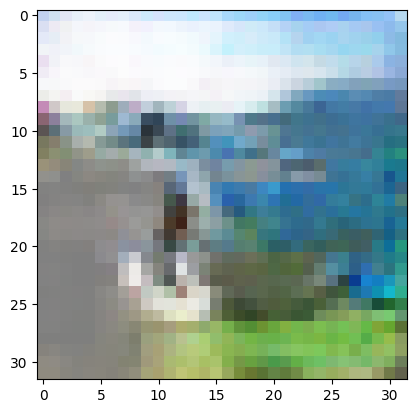

In [16]:
# generation to image
G.eval()
imshow(get_sample_image(G, n_noise)[0])

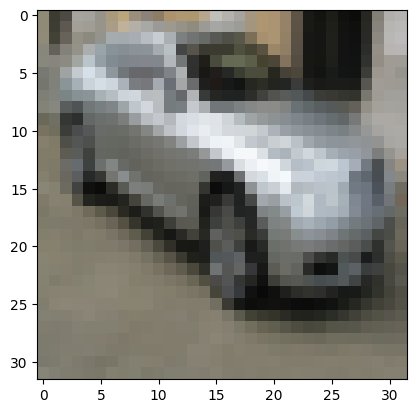

In [17]:
# Real Image
t = Image.open(dataset.fpaths[999])
t = (transform(t).permute(1, 2, 0)+1)/2.
imshow(t)

In [4]:
!zip /kaggle/working/samples.zip


zip error: Nothing to do! (/kaggle/working/samples.zip)
